In [1]:
from fastai.vision.all import *
from functools import partial
from pathlib import Path

In [2]:
path = Path('/Users/mohammadtalha/Documents/Projects/Wickly/ml/model')

#list class folders
classes= [p.name for p in path.iterdir() if p.is_dir()]
print('Classes found:', classes)

#count images per class
for c in classes:
    print(f'Class {c} has {len(list((path/c).iterdir()))} images')

Classes found: ['hammer', 'models', 'none']
Class hammer has 100 images
Class models has 0 images
Class none has 95 images


In [3]:
chart_tfms= aug_transforms(
    do_flip=False,
    max_rotate=0.0,
    max_zoom=1.05,
    max_warp=0.05,
    max_lighting=0.1,
    p_affine=0.75,
    p_lighting=0.75,
    size=224,
)

In [4]:
from collections import Counter
from fastai.vision.all import *

print(path)  # make sure this is the folder that directly contains 'hammer' and 'none'
files = get_image_files(path)
print("Overall class counts:", Counter(f.parent.name for f in files))

# Peek a few hammer files
h = [f for f in files if f.parent.name=='hammer'][:5]
print("Sample hammer files:", [str(x.name) for x in h])

/Users/mohammadtalha/Documents/Projects/Wickly/ml/model
Overall class counts: Counter({'hammer': 100, 'none': 94})
Sample hammer files: ['hammer_096.png', 'hammer_082.png', 'hammer_055.png', 'hammer_041.png', 'hammer_069.png']


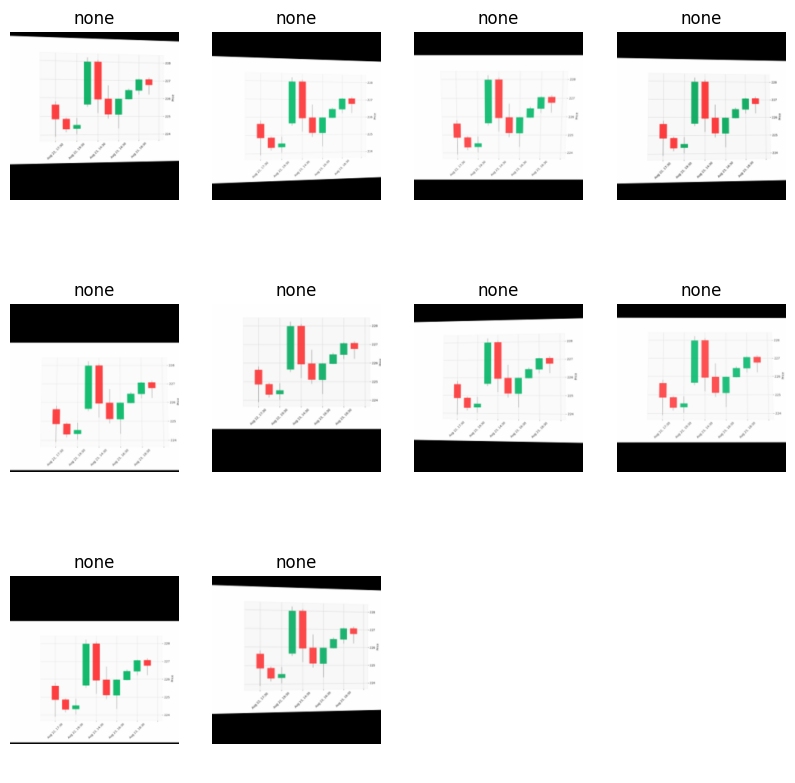

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # <-- lock split only
    get_y=lambda o: [o.parent.name],
    item_tfms=Resize(256, method='pad', pad_mode='zeros'),
    batch_tfms=aug_transforms(do_flip=False, max_rotate=0.0, max_zoom=1.05,
                              max_warp=0.05, max_lighting=0.12, size=224)
)
dls = dblock.dataloaders(path, bs=32, num_workers=0)
dls.show_batch(max_n=10, figsize=(10,10), unique=True) #show batch of images

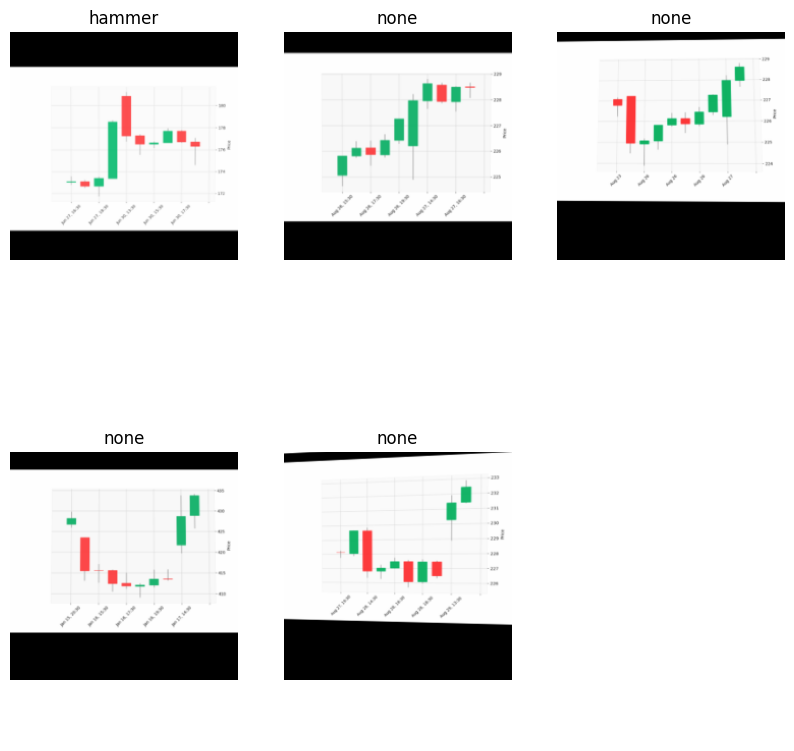

In [145]:
xb, yb = dls.one_batch()  # grabs a random batch
dls.show_batch((xb, yb), max_n=5, figsize=(10,10))

In [134]:
from collections import Counter
from pathlib import Path
from fastai.vision.all import *

print("Root path:", path)
all_files = get_image_files(path)
print("Overall counts:", Counter(f.parent.name for f in all_files))

train_files = list(dls.train.items)
valid_files = list(dls.valid.items)

print("Train counts:", Counter(Path(f).parent.name for f in train_files))
print("Valid counts:", Counter(Path(f).parent.name for f in valid_files))

print("len(train_ds) =", len(dls.train_ds), " | bs =", dls.bs)

Root path: /Users/mohammadtalha/Documents/Projects/Wickly/ml/model
Overall counts: Counter({'hammer': 100, 'none': 94})
Train counts: Counter({'hammer': 79, 'none': 77})
Valid counts: Counter({'hammer': 21, 'none': 17})
len(train_ds) = 156  | bs = 32


In [133]:
train_files = list(dls.train.items)
valid_files = list(dls.valid.items)

from collections import Counter
print("Train counts:", Counter(Path(f).parent.name for f in train_files))
print("Valid counts:", Counter(Path(f).parent.name for f in valid_files))

Train counts: Counter({'hammer': 79, 'none': 77})
Valid counts: Counter({'hammer': 21, 'none': 17})


In [123]:
learn = cnn_learner(
    dls, resnet34,
    metrics=partial(accuracy_multi, thresh=0.5)
)

learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.055720,1.244835,0.552632,00:06


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.934812,0.975380,0.552632,00:06
1,0.929272,0.833246,0.605263,00:06
2,0.812475,0.691199,0.657895,00:06
3,0.768993,0.610473,0.697368,00:06


In [124]:
# === ARGMAX EVALUATION 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) get predictions (probs) and the true labels (one-hot) for the validation set
preds, targs = learn.get_preds()

# 2) get your label order, e.g. ['hammer','none']
lab_order = list(dls.vocab)

# 3) figure out which column is 'hammer' and which is 'none'
i_h = lab_order.index('hammer')
i_n = lab_order.index('none')

# 4) build predicted labels using ARGMAX (pick the bigger prob)
pred_lbls_argmax = ['hammer' if float(p[i_h]) >= float(p[i_n]) else 'none' for p in preds]

# 5) build the true labels from the one-hot targets
true_lbls = [lab_order[int(i)] for i in targs.argmax(dim=1)]



In [125]:
from sklearn.metrics import f1_score  # Import f1_score from sklearn.metrics

preds, targs = learn.get_preds() #preds: (N,C) probs; targs: (N,C) one-hot
print("Label order:", dls.vocab) #see the class order

y_true = targs.numpy() #convert tensor to numpy for sklearn
y_pred = (preds.numpy() >= 0.5).astype(int) #apply 0.5 threshold 0/1 per class
print("Macro F1:", f1_score(y_true, y_pred, average='macro', zero_division=0))
print("Micro F1:", f1_score(y_true, y_pred, average='micro', zero_division=0))

Label order: ['hammer', 'none']
Macro F1: 0.598343685300207
Micro F1: 0.6461538461538462


In [126]:
test_img = dls.valid_ds.items[0] #pick any validation image
labels, bin_vec, probs = learn.predict(test_img) #run model on that image
print("Image:", test_img.name) #print filename
print("Predicted labels:", labels) #string of labels above fast ai;s default threshold
print("Probabilities:", probs) #raw probabiliteis aligned with dls.vocab

Image: hammer_084.png
Predicted labels: ['hammer']
Probabilities: tensor([0.7666, 0.2533])


In [127]:
from pathlib import Path

lab_order = dls.vocab  # e.g. ['hammer','none']


In [130]:
# 6) print metrics
print("=== Argmax-based Evaluation ===")
print("Accuracy:", accuracy_score(true_lbls, pred_lbls_argmax))
print("Confusion matrix label order:", lab_order)
print(confusion_matrix(true_lbls, pred_lbls_argmax, labels=lab_order))
print("\nClassification report:")
print(classification_report(true_lbls, pred_lbls_argmax, target_names=lab_order, zero_division=0))

=== Argmax-based Evaluation ===
Accuracy: 0.6842105263157895
Confusion matrix label order: ['hammer', 'none']
[[19  2]
 [10  7]]

Classification report:
              precision    recall  f1-score   support

      hammer       0.66      0.90      0.76        21
        none       0.78      0.41      0.54        17

    accuracy                           0.68        38
   macro avg       0.72      0.66      0.65        38
weighted avg       0.71      0.68      0.66        38



In [121]:
from fastai.vision.all import *
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 0) Make sure your split is stable
# (Only do this once when you build dls)
# splitter = RandomSplitter(valid_pct=0.2, seed=42)

# 1) Recreate the learner and re-run the BEST epoch count
best_e = 4  # <= set this to what the sweep printed
learn = cnn_learner(dls, resnet34, metrics=None)

# (re)pick LR safely
lr_f = learn.lr_find()
lr = lr_f.valley or lr_f.minimum or 1e-3
print("LR used:", lr)

# Train exactly best_e epochs
learn.fine_tune(best_e, base_lr=lr)



# 2) Evaluate with ONE rule: ARGMAX
preds, targs = learn.get_preds()
labs = list(learn.dls.vocab)
true_idx = targs.argmax(dim=1) if targs.ndim == 2 else targs
pred_idx = preds.argmax(dim=1)

acc = (pred_idx == true_idx).float().mean().item()
cm  = confusion_matrix(true_idx.cpu(), pred_idx.cpu(), labels=range(len(labs)))
print("Vocab:", labs)
print("Accuracy:", round(acc, 4))
print("Confusion matrix (rows=actual idx, cols=pred idx):\n", cm)
print("\nReport:")
print(classification_report(true_idx.cpu(), pred_idx.cpu(), target_names=labs, zero_division=0))

/Users/mohammadtalha/Documents/Projects/Wickly/.venv/lib/python3.11/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


/Users/mohammadtalha/Documents/Projects/Wickly/.venv/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 

Using LR: 0.0014454397605732083

=== Training for 1 epoch(s) ===


epoch,train_loss,valid_loss,time
0,1.077226,1.424695,00:04


epoch,train_loss,valid_loss,time
0,0.849793,1.409513,00:06


Epochs: 1, Accuracy: 0.4474

=== Training for 2 epoch(s) ===


epoch,train_loss,valid_loss,time
0,1.066682,0.921002,00:04


epoch,train_loss,valid_loss,time
0,1.037160,0.851867,00:06
1,0.887512,0.790675,00:06


Epochs: 2, Accuracy: 0.5263

=== Training for 3 epoch(s) ===


epoch,train_loss,valid_loss,time
0,0.955706,1.372309,00:04


epoch,train_loss,valid_loss,time
0,1.016530,1.173992,00:06
1,0.950677,1.143172,00:05
2,0.909369,0.958550,00:06


Epochs: 3, Accuracy: 0.4737

=== Training for 4 epoch(s) ===


epoch,train_loss,valid_loss,time
0,1.096871,0.829016,00:06


epoch,train_loss,valid_loss,time
0,0.950837,0.656254,00:05
1,0.954865,0.526886,00:05
2,0.865951,0.548347,00:05
3,0.829168,0.603523,00:05


Epochs: 4, Accuracy: 0.8158

=== Training for 5 epoch(s) ===


epoch,train_loss,valid_loss,time
0,1.100100,0.840709,00:04


epoch,train_loss,valid_loss,time
0,0.896265,0.805605,00:07
1,0.835864,0.749885,00:06
2,0.812042,0.754426,00:06
3,0.791619,0.732648,00:06
4,0.758176,0.640432,00:06


Epochs: 5, Accuracy: 0.6579

=== Training for 6 epoch(s) ===


epoch,train_loss,valid_loss,time
0,1.087144,0.752552,00:04


epoch,train_loss,valid_loss,time
0,1.002633,0.741368,00:06
1,0.960857,0.671146,00:06
2,0.923979,0.669872,00:06
3,0.865523,0.742176,00:05
4,0.827441,0.759016,00:06
5,0.799973,0.733532,00:07


Epochs: 6, Accuracy: 0.6053

=== Training for 7 epoch(s) ===


epoch,train_loss,valid_loss,time
0,0.926487,0.803453,00:04


epoch,train_loss,valid_loss,time
0,0.828177,0.634778,00:06
1,0.847325,0.633164,00:06
2,0.806977,0.644620,00:05
3,0.781691,0.620280,00:09
4,0.760210,0.656854,00:08
5,0.714761,0.689034,00:06
6,0.686906,0.687766,00:06


Epochs: 7, Accuracy: 0.7105

Best fine_tune is 4 epochs with accuracy 0.8158


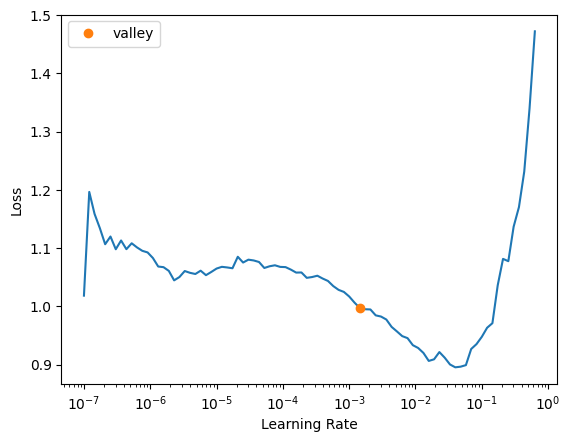

In [ ]:
from fastai.vision.all import *
from sklearn.metrics import accuracy_score


# 0) Build a learner just to find a good LR (no metrics to avoid shape issues)
learn = cnn_learner(dls, resnet34, metrics=None)
lr_f = learn.lr_find()
lr_min = lr_f.valley or lr_f.minimum or 1e-3
print("Using LR:", lr_min)


results = {}


# 1..10 epochs: train fresh each time (simple & reliable)
for e in range(1, 8):
   print(f"\n=== Training for {e} epoch(s) ===")
   # fresh learner each run; no metrics so Recorder won't crash on shapes
   learn = cnn_learner(dls, resnet34, metrics=None)
   learn.fine_tune(e, base_lr=lr_min)


   # validate using argmax (works for both one-hot or single-label)
   preds, targs = learn.get_preds()


   if targs.ndim == 2:
       # one-hot → single label per image
       true_idx = targs.argmax(dim=1)
   else:
       true_idx = targs


   pred_idx = preds.argmax(dim=1)
   acc = (pred_idx == true_idx).float().mean().item()
   results[e] = acc
   print(f"Epochs: {e}, Accuracy: {acc:.4f}")


# Best epoch count
best_e = max(results, key=lambda k: results[k])
print(f"\nBest fine_tune is {best_e} epochs with accuracy {results[best_e]:.4f}")

